# Andrew Ng's Machine Learning MOOC: Week 2: Linear Regression

# Programming Exercise 1: Univariate and Multivariate Linear Regression


## Introduction
This notebook contains my solutions to the programming exercise for week 2 of Andrew Ng's famous Machine Learning MOOC on Coursera (https://www.coursera.org/learn/machine-learning).

The course requires submission of programming exercises in either the MATLAB or OCTAVE programming language.

However since:
- I already code in Python for various web development and data science projects, and
- Python is the pre-eminent language currently used in data science and machine learning (and MATLAB and OCTAVE don't seem to be used anywhere near as much)

I decided it would be more valuable to me to use Python to complete the programming exercises.

I was therefore very pleased to find the following source, which has kindly written a set of python scripts to allow one to create Python implementations of the programming exercises for the course, and <i><b>still submit them</i></b> for scoring:

https://github.com/dibgerge/ml-coursera-python-assignments

Thanks very much <i>dibgerge</i>!

In addition to the course's own lecture materials, I also used a number of other sources to help me solve the programming exercises. These include:

**Other courses** I've completed:
- Harvard's <i>Using Python for Research</i> on edX: https://www.edx.org/course/using-python-for-research
- UC San Diego's <i>Python for Data Science</i>, also on edX: https://www.edx.org/course/python-for-data-science-2
- MIT's <i>Introduction to Computational Thinking and Data Science</i>, also on edX: https://www.edx.org/course/introduction-to-computational-thinking-and-data-4

**Books**:
<i>Python Machine Learning</i> by Sebastian Raschka and Vahid Mirjalili: https://sebastianraschka.com/books.html

**Blogs and websites**:
I found these two blogs useful references

https://www.johnwittenauer.net/machine-learning-exercises-in-python-part-1/

https://medium.com/analytics-vidhya/python-implementation-of-andrew-ngs-machine-learning-course-part-1-6b8dd1c73d80

And of course, there's always StackOverflow!

One thing that struck me, looking at all of these different resources, is <i>how many different ways</i> there are to implement basically the same code in python, even using numpy and pandas dataframes! And that's before we think about object-oriented implementations, or using libraries such as scikitlearn.

OK, now that the introduction is complete, let's get started with some imports:

In [273]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Pandas for large data sets
import pandas as pd

# Plotting library
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed to plot 3-D surfaces

# library written for this exercise providing additional functions for assignment submission, and others
import utils 

# define the submission/grader object for this exercise
grader = utils.Grader()

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## 1 Linear regression with one variable

To start with we will implement linear regression with one variable to predict profits for a food truck. Suppose you are the CEO of a restaurant franchise and are considering different cities for opening a new outlet. The chain already has trucks in various cities and you have data for profits and populations from the cities. You would like to use this data to help you select which city to expand to next. 

The file `Data/ex1data1.txt` contains the dataset for our linear regression problem. The first column is the population of a city (in 10,000s) and the second column is the profit of a food truck in that city (in $10,000s). A negative value for profit indicates a loss. 

### 1.1 Plotting the Data

Before starting on any task, it's almost always a good idea to understand the data by visualizing it. For this dataset, you can use a scatter plot to visualize the data, since it has only two properties to plot (profit and population).

There are many plotting libraries in python (see this [blog post](https://blog.modeanalytics.com/python-data-visualization-libraries/) for a good summary of the most popular ones). 

`matplotlib` is one of the most popular scientific plotting libraries in python and has extensive tools and functions to make beautiful plots.

`pyplot` is a module within `matplotlib` which provides a simplified interface to `matplotlib`'s most common plotting tasks, mimicking MATLAB's plotting interface.

I'll be using `matplotlib` and `pyplot` to do my plotting in this notebook.

#### 1.1.1 Using pandas data frames

`Pandas` is another very commonly used Python library for dealing with large datasets. I tend to think of it as offering some of the functionality of a large spreadsheet (although in my experience it's far <i>less</i> user-friendly than a spreadsheet!). Basically it allows you to create large multidimensional tables of data - called `dataframes` - and then run operations on them <i>very fast</i>.

Because it's so commonly used, I wanted to use it to load and view the data for these exercises.

**Be warned** though - there are some peculiarities about the way that `numpy` expects data to be presented (in particular, the shapes and types of arrays that are used for vector operations), which it's easy to get wrong when moving between `pandas` dataframes and `numpy` arrays - even though `pandas` is built on top of `numpy` arrays (as far as I understand it).

Anyway, to get started, we need to load, or "<i>read</i>" our data into a `pandas` data frame:

In [274]:
# read the data into a pandas dataframe
data = pd.read_csv('Data/ex1data1.txt', header = None, names=['Population', 'Profit']) #read from dataset
data.head() # view first few rows of the data

,Population,Profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


Now let's have a look at the shape of the dataframe:

In [275]:
data.shape

(97, 2)

In [276]:
data.describe()

,Population,Profit
count,97.000000,97.000000
mean,8.159800,5.839135
std,3.869884,5.510262
min,5.026900,-2.680700
25%,5.707700,1.986900
50%,6.589400,4.562300
75%,8.578100,7.046700
max,22.203000,24.147000


#### 1.1.2 Plotting the data

OK, this looks like we were expecting. Now let's have a look at the data by creating a scatter plot:

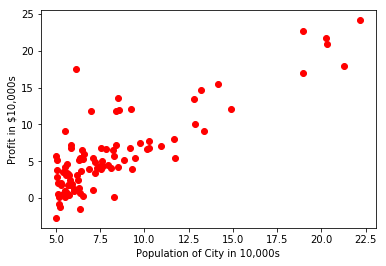

In [277]:
plt.scatter(data.Population, data.Profit, marker = "o", color = "r")
plt.xlabel('Population of City in 10,000s')
plt.ylabel('Profit in $10,000s')
plt.show()

**Note**
It would be useful at this stage to do a couple of things:
1. Define a function to plot the data, that can be called, rather than plotting each time
2. Use matplotlib / pyplot's object-oriented capability to plot figures (e.g. defining a "figure" and "axes")

However, I'm not going to do that right now!

**Note**
To quickly learn more about the `matplotlib` plot function and what arguments you can provide to it, you can type `?pyplot.plot` in a cell within the jupyter notebook. This opens a separate page showing the documentation for the requested function. You can also search online for plotting documentation.

### 1.2 Gradient Descent

In this part, we fit the linear regression parameters $\theta$ to our dataset using gradient descent.

#### 1.2.1 The Equations

The objective of linear regression is to minimize the cost function

$$ J(\theta) = \frac{1}{2m} \sum_{i=1}^m \left( h_{\theta}(x^{(i)}) - y^{(i)}\right)^2$$

where the hypothesis $h_\theta(x)$ is given by the linear model
$$ h_\theta(x) = \theta^Tx = \theta_0 + \theta_1 x_1$$

If this looks unfamiliar, it might help to remember from your school maths class that the equation for a straight line is $y = mx + c$

or, as expressed above, $y = c + mx$


Now, the parameters of your model are the $\theta_j$ values

$(m$ and $c$ in our equation for the line).

These are the values you will adjust to minimize cost $J(\theta)$. One way to do this is to
use the batch gradient descent algorithm. In batch gradient descent, each iteration performs the update

$$ \theta_j = \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)}\right)x_j^{(i)} \qquad \text{simultaneously update } \theta_j \text{ for all } j$$

With each step of gradient descent, your parameters $\theta_j$ come closer to the optimal values that will achieve the lowest cost

$J(\theta)$.

#### 1.2.2 Implementation

#### First - we need to get the data ready

Remember that, in the equation for gradient descent, we need to add another dimension to our data to accommodate the $\theta_0$ intercept term. We initialize this so that every value in this dimension = 1.

We do this in the following cell - **Do NOT execute this cell more than once!**:

If, by mistake, you **do** end up executing this cell more than once, then go back and re-run the code to load the data (in section 1.1.1)

In [278]:
# append a ones column to the front of the data set
data.insert(0, 'Ones', 1)

In [279]:
data.head()

,Ones,Population,Profit
0,1,6.1101,17.5920
1,1,5.5277,9.1302
2,1,8.5186,13.6620
3,1,7.0032,11.8540
4,1,5.8598,6.8233


Now, for the link to the Coursera course grader to work, this notebook needs to output using array-like outputs.
(I'm not totally sure, but this may also be a requirement for the `scikitlearn` library we're going to use later)
To do this, we extract X (the independent variables, or "training data") and y (the dependent, or "target" variable) from our dataframe.

In [280]:
# set X (training data) and y (target variable)
cols = data.shape[1] # instantiate a variable "cols" to represent the number of columns in the data frame
X = data.iloc[:,0:cols-1] # read first n-1 columns
y = data.iloc[:,cols-1:cols] # read last (nth) column

Finally, we need to instantiate a matrix to hold our $\theta$ parameters, which we will initialize to 0:

In [281]:
theta = np.zeros([2,1])

Let's check we're getting what we expect for X, y and theta:

In [282]:
X.shape

(97, 2)

In [283]:
y.shape

(97, 1)

In [284]:
theta.shape

(2, 1)

In [285]:
X

,Ones,Population
0,1,6.1101
1,1,5.5277
2,1,8.5186
3,1,7.0032
4,1,5.8598
5,1,8.3829
6,1,7.4764
7,1,8.5781
8,1,6.4862
9,1,5.0546


In [286]:
y

,Profit
0,17.59200
1,9.13020
2,13.66200
3,11.85400
4,6.82330
5,11.88600
6,4.34830
7,12.00000
8,6.59870
9,3.81660


In [287]:
theta

array([[ 0.],
       [ 0.]])

**Note** that this is a 2-row by 1-column matrix

Finally, we also initialize the number of interations to 1,500 and the learning rate alpha to 0.01:

In [288]:
iterations = 1500
alpha = 0.01

Now we calculate our hypothesis $h_\theta(x)$, which from 1.2.1 above we see is defined as

$\theta^Tx$

In [289]:
X.dot(theta)

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


<a id="section2"></a>
#### 1.2.3 Computing the cost $J(\theta)$

As we perform gradient descent to learn minimize the cost function $J(\theta)$, it is helpful to monitor the convergence by computing the cost. To help us do this, we implement a function to calculate $J(\theta)$ so we can check the convergence of the gradient descent implementation. 

Remember that the variables $X$ and $y$ are not scalar values. $X$ is a matrix whose rows represent the examples from the training set and $y$ is a vector whose each element represents the value at a given row of $X$.
<a id="computeCost"></a>

In [290]:
def computeCost(X, y, theta):
    """
    Compute cost for linear regression. Computes the cost of using theta as the
    parameter for linear regression to fit the data points in X and y.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n+1), where m is the number of examples,
        and n is the number of features. We assume a vector of 1s is already 
        appended to the features so we have n+1 columns.
    
    y : array_like
        The values of the function at each data point. This is a vector of
        shape (m, 1)
    
    theta : array_like
        The parameters for the regression function. This is a vector of 
        shape (n+1, 1).
    
    Returns
    -------
    J : float
        The value of the regression cost function.
    """
    J_temp = np.dot(X, theta) - y
    J_temp = np.power(J_temp, 2)
    m = len(y)
    J = np.sum(J_temp) / (2*m)
    return J

Now we will run `computeCost` using three different initializations of $\theta$. In each case, the cost is printed to the screen. I've also left in some debugging `print` statements that look at the shape of theta - which is useful because numpy and pandas don't necessarily "play nicely" together!

In [291]:
J = computeCost(X, y, theta)
print("J is {}".format(J))
print("J's shape is {}".format(J.shape))
print('With theta = [0, 0] \nCost computed = %.2f' % J)
print('Expected cost value (approximately) 32.07\n')

J is Profit    32.072734
dtype: float64
J's shape is (1,)
With theta = [0, 0] 
Cost computed = 32.07
Expected cost value (approximately) 32.07



A second test of the `computeCost` function

In [292]:
# further testing of the cost function
theta2 = np.array([-1,2])
#print("Theta2 is {}".format(theta2))
#print("Theta2's shape is{}".format(theta2.shape))
theta2 = theta2[:,np.newaxis]
#print("Theta2 is now {}".format(theta2))
#print("Theta2's shape is now {}".format(theta2.shape))
J = computeCost(X, y, theta2)
print('With theta = [-1, 2]\nCost computed = %.2f' % J)
print('Expected cost value (approximately) 54.24')

With theta = [-1, 2]
Cost computed = 54.24
Expected cost value (approximately) 54.24


And one further test case from the course's forum:

In [293]:
X3 = np.array([[1, 1, 1, 1], [2, 3, 4, 5]])
X3 = X3.T
#print("X3 is {}".format(X3))
#print("X3's shape is {}".format(X3.shape))
y3 = np.array([[7, 6, 5, 4]])
y3 = y3.T
#print("y3 is {}".format(y3))
#print("y3's shape is {}".format(y3.shape))
theta3 = np.array([0.1, 0.2])
theta3 = theta3[:,np.newaxis]
#print("theta3 is {}".format(theta3))
#print("theta3's shape is {}".format(theta3.shape))
print("Test case 3: expected value 11.9450")
print("Output:")
print(computeCost(X3, y3, theta3))

Test case 3: expected value 11.9450
Output:
11.945


#### 1.2.4 Gradient Descent

Next, we implement a function for gradient descent. 

The cost $J(\theta)$ is parameterized by the vector $\theta$, not $X$ and $y$.

That is, we minimize the value of $J(\theta)$ by changing the values of the vector $\theta$, not by changing $X$ or $y$. A good way to verify that gradient descent is working correctly is to look at the value of $J(\theta)$ and check that it is decreasing with each step.

<div class="alert alert-box alert-warning">
**Vectors and matrices in `numpy`** - Important implementation notes

A vector in `numpy` is a one dimensional array, for example `np.array([1, 2, 3])` is a vector. A matrix in `numpy` is a two dimensional array, for example `np.array([[1, 2, 3], [4, 5, 6]])`. However, the following is still considered a matrix `np.array([[1, 2, 3]])` since it has two dimensions, even if it has a shape of 1x3 (which looks like a vector).

Given the above, the function `np.dot` which we will use for all matrix/vector multiplication has the following properties:
- It always performs inner products on vectors. If `x=np.array([1, 2, 3])`, then `np.dot(x, x)` is a scalar.
- For matrix-vector multiplication, so if $X$ is a $m\times n$ matrix and $y$ is a vector of length $m$, then the operation `np.dot(y, X)` considers $y$ as a $1 \times m$ vector. On the other hand, if $y$ is a vector of length $n$, then the operation `np.dot(X, y)` considers $y$ as a $n \times 1$ vector.
- A vector can be promoted to a matrix using `y[None]` or `[y[np.newaxis]`. That is, if `y = np.array([1, 2, 3])` is a vector of size 3, then `y[None, :]` is a matrix of shape $1 \times 3$. We can use `y[:, None]` to obtain a shape of $3 \times 1$.
<div>
<a id="gradientDescent"></a>





Now we define our algorithm for gradient descent:

In [294]:
def gradientDescent(X, y, theta, alpha, num_iters):
    """
    Performs gradient descent to learn `theta`. Updates theta by taking `num_iters`
    gradient steps with learning rate `alpha`.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n+1).
    
    y : array_like
        Value at given features. A vector of shape (m, ).
    
    theta : array_like
        Initial values for the linear regression parameters. 
        A vector of shape (n+1, ).
    
    alpha : float
        The learning rate.
    
    num_iters : int
        The number of iterations for gradient descent. 
    
    Returns
    -------
    theta : array_like
        The learned linear regression parameters. A vector of shape (n+1, ).
    
    J_history : list
        A python list for the values of the cost function after each iteration.
    
    Instructions
    ------------
    Peform a single gradient step on the parameter vector theta.

    While debugging, it can be useful to print out the values of 
    the cost function (computeCost) and gradient here.
    """
    # Initialize some useful values
    m = len(y)  # number of training examples
    
    # make a copy of theta, to avoid changing the original array, since numpy arrays
    # ...are passed by reference to functions
    theta = theta.copy()
    
    J_history = [] # Use a python list to save cost for every iteration
    
    for i in range(num_iters):
        # calculate an updated value of theta by taking a step down the gradient
        error = np.dot(X, theta) - y
        temp = np.dot(X.T, error)
        temp = (alpha/m)*temp
        theta = theta - temp
        # save the cost J in every iteration
        J_history.append(computeCost(X, y, theta))
    
    return theta, J_history

Let's check this works. We'll initialize the $\theta$ parameters to 0 and the learning rate $\alpha$ to 0.01, and print the output vs. the expected values (provided by the course and `dibmerge`).

In [297]:
# initialize fitting parameters
theta = np.zeros([2,1])

# some gradient descent settings
iterations = 1500
alpha = 0.01

theta, J_history = gradientDescent(X ,y, theta, alpha, iterations)
print('Theta found by gradient descent: {}'.format(theta))
print('Expected theta values (approximately): [-3.6303, 1.1664]')

Theta found by gradient descent: [[-3.63029144]
 [ 1.16636235]]
Expected theta values (approximately): [-3.6303, 1.1664]


Now we plot the linear fit

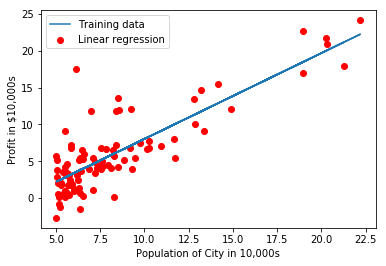

In [298]:
# plot the linear fit
plt.scatter(X.iloc[:, 1], y, marker = "o", color = "r")
plt.xlabel('Population of City in 10,000s')
plt.ylabel('Profit in $10,000s')
plt.plot(X.iloc[:, 1], np.dot(X, theta), '-')
plt.legend(['Training data', 'Linear regression']);
plt.show()

Finally, we can use the values for $\theta$ that we generated using gradient descent to make predictions of profits in areas with populations 35,000 and 70,000 people.

<div class="alert alert-block alert-success">
Note the way that the following lines use matrix multiplication, rather than explicit summation or looping, to calculate the predictions. This is an example of code vectorization in `numpy`.
</div>

<div class="alert alert-block alert-success">
Note that the first argument to the `numpy` function `dot` is a python list. `numpy` can internally convert **valid** python lists to numpy arrays when explicitly provided as arguments to `numpy` functions.
</div>


In [299]:
# Predict values for population sizes of 35,000 and 70,000
predict1 = np.dot([1, 35000], theta)
print('For population = 35,000, we predict a profit of ${}\n'.format(predict1))

predict2 = np.dot([1, 70000], theta)
print('For population = 70,000, we predict a profit of ${}\n'.format(predict2))

For population = 35,000, we predict a profit of $[ 40819.05197031]

For population = 70,000, we predict a profit of $[ 81641.73423205]



### 1.3 Visualizing $J(\theta)$

As a first visualisation, let's create a chart of $J(\theta)$ vs. the number of training iterations

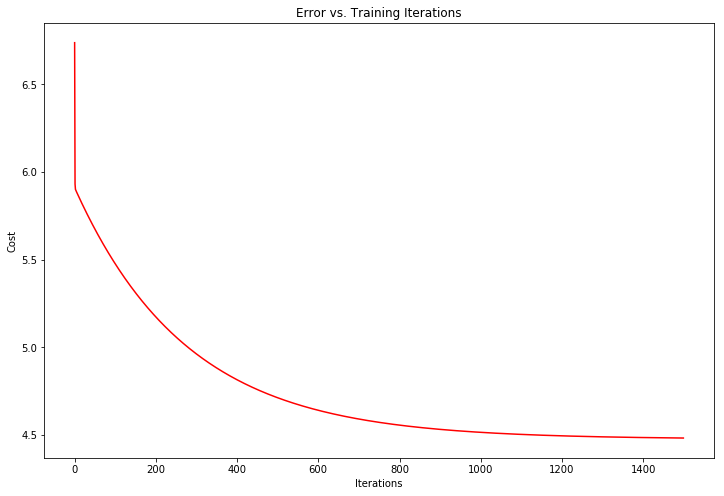

In [300]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(iterations), J_history, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Iterations')

To understand the cost function $J(\theta)$ better, we can plot the cost over a 2-dimensional grid of $\theta_0$ and $\theta_1$ values.

The code in the next cell does the following:
- First we create a 100 x 100 2-D array - think of this as the $xy$ plane
- Next, we calculate the value of $J(\theta)$ at every point on that plane
- Lastly, we use those values to produce surface and contour plots of $J(\theta)$ using the matplotlib `plot_surface` and `contourf` functions.

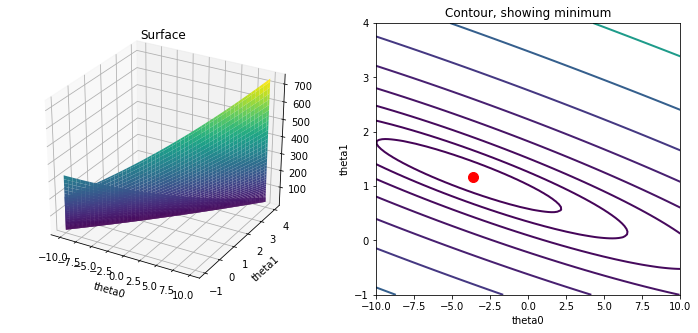

In [301]:
# instantiate a 100 x 100 grid over which we will calculate J
theta0_vals = np.linspace(-10, 10, 100)
theta1_vals = np.linspace(-1, 4, 100)

# initialize J_vals to a matrix of 0's
J_vals = np.zeros((theta0_vals.shape[0], theta1_vals.shape[0]))

# Fill out J_vals
for i, theta0 in enumerate(theta0_vals):
    for j, theta1 in enumerate(theta1_vals):
        # ensure theta has the right dimensions - for my implementation to work, needs to be a 2 x 1 vector
        theta_temp = np.array([theta0, theta1])
        theta_temp = theta_temp[:,np.newaxis]
        J_vals[i, j] = computeCost(X, y, theta_temp)
        
        
# Because of the way meshgrids work in the plot_surface() command, we need to
# ...transpose J_vals before calling plot_surface(), or else the axes will be flipped
J_vals = J_vals.T

# surface plot
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(theta0_vals, theta1_vals, J_vals, cmap='viridis')
plt.xlabel('theta0')
plt.ylabel('theta1')
plt.title('Surface')

# contour plot
# Plot J_vals as 15 contours spaced logarithmically between 0.01 and 100
ax = plt.subplot(122)
plt.contour(theta0_vals, theta1_vals, J_vals, linewidths=2, cmap='viridis', levels=np.logspace(-2, 3, 20))
plt.xlabel('theta0')
plt.ylabel('theta1')
plt.plot(theta[0], theta[1], 'ro', ms=10, lw=2)
plt.title('Contour, showing minimum')
pass

The graphs is show us how $J(\theta)$ varies with changes in $\theta_0$ and $\theta_1$. The cost function $J(\theta)$ is bowl-shaped and has a global minimum. (This is easier to see in the contour plot than in the 3D surface plot). This minimum is the optimal point for $\theta_0$ and $\theta_1$, and each step of gradient descent moves closer to this point.

## Optional Exercises

The exercises for this part of the course also include some optional exercises to better understand the material.

## 2 Linear regression with multiple variables

In this part, we will implement linear regression with multiple variables to predict the prices of houses. Suppose you are selling your house and you want to know what a good market price would be. One way to do this is to first collect information on recent houses sold and make a model of housing prices.

The file `Data/ex1data2.txt` contains a training set of housing prices in Portland, Oregon. The first column is the size of the house (in square feet), the second column is the number of bedrooms, and the third column is the price of the house.

Let's load the data and take a look at it. I'm going to do this using a pandas dataframe (as I did above) because this makes it easier to complete the normalization.

In [302]:
# Load data
data2 = pd.read_csv('Data/ex1data2.txt', header=None, names=['Size', 'Bedrooms', 'Price'])
data2.head()

,Size,Bedrooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


### 2.1 Feature Normalization

By looking at the values, note that house sizes are about 1000 times the number of bedrooms. When features differ by several orders of magnitude,  feature scaling can make gradient descent converge much more quickly.

We do this by defining a `featureNormalize` function that does the following:
- Subtract the mean value of each feature from the dataset.
- After subtracting the mean, additionally scale (divide) the feature values by their respective “standard deviations.”

The standard deviation is a way of measuring how much variation there is in the range of values of a particular feature (most data points will lie within ±2 standard deviations of the mean); this is an alternative to taking the range of values (max-min). Using a pandas data frame, we can compute this very quickly using the `std()` method.

You will do this for all the features and your code should work with datasets of all sizes (any number of features / examples). Note that each column of the matrix $X$ corresponds to one feature.

<div class="alert alert-block alert-warning">
**Implementation Note:** When normalizing the features, it is important
to store the values used for normalization - the mean value and the standard deviation used for the computations. After learning the parameters
from the model, we often want to predict the prices of houses we have not
seen before. Given a new x value (floor area and number of bedrooms), we must first normalize x using the mean and standard deviation that we had previously computed from the training set.
</div>

First we will define a function to normalize the values of any input matrix X:

In [303]:
def  featureNormalize(X):
    """
    Normalizes the features in X. returns a normalized version of X where
    the mean value of each feature is 0 and the standard deviation
    is 1.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n).
    
    Returns
    -------
    X_norm : a pandas data frame representing the normalized dataset of shape (m x n).
        
    X_mean : a pandas series containing floats of the means of each item in X

    X_std : a pandas series containing floats of the standard deviations of each item in X
    
    Notes
    ------------
    As a pandas data frame, we can compute this very quickly - in three lines as below.
    However, note that the grader for the Coursera course won't accept a pandas dataframe,
    or a pandas series, as input - so we'll need to select our data from this data frame later
    """
    # compute the mean, standard deviation of each column in the data frame, and then normalise  
    X_mean = X.mean()
    X_std = X.std()
    X_normed = (X - X_mean) / X_std
    return X_normed, X_mean, X_std

Now we run our `featureNormalize()` function.

In [304]:
# call featureNormalize on the loaded data
X_norm, X_mean, X_std = featureNormalize(data2)
print('Computed mean:', X_mean)
print('Computed standard deviation:', X_std)

Computed mean: Size          2000.680851
Bedrooms         3.170213
Price       340412.659574
dtype: float64
Computed standard deviation: Size           794.702354
Bedrooms         0.760982
Price       125039.899586
dtype: float64


In [305]:
X_norm.head()

,Size,Bedrooms,Price
0,0.130010,-0.223675,0.475747
1,-0.504190,-0.223675,-0.084074
2,0.502476,-0.223675,0.228626
3,-0.735723,-1.537767,-0.867025
4,1.257476,1.090417,1.595389


Now I'm going to create a test case that I can re-create in excel to test that the output is what I'd expect, arithmetically

In [306]:
Test1 = data2[0:5].copy()

In [307]:
Test1

,Size,Bedrooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


Now we'll normalize this and see what the output looks like

In [308]:
# call featureNormalize on  Test1
X_norm_T1, X_mean_T1, X_std_T1 = featureNormalize(Test1)

In [309]:
X_norm_T1

,Size,Bedrooms,Price
0,0.000000,0.000000,0.229654
1,-0.792500,0.000000,-0.394406
2,0.465436,0.000000,-0.045824
3,-1.081825,-1.414214,-1.267198
4,1.408889,1.414214,1.477773


In [310]:
X_mean_T1

Size          2104.0
Bedrooms         3.0
Price       374140.0
dtype: float64

In [311]:
X_std_T1

Size           635.962263
Bedrooms         0.707107
Price       112168.770164
dtype: float64

**Note!** Pandas defines the denominator for the standard deviation as <i>(n -1)</i> - which is the standard deviation of the <i>sample</i> - which is what we'd expect.

I wonder if the grader expects <i>n</i>?

Let's look at a few other test cases from the course's forum and see what results they expect

In [312]:
Test2 = pd.DataFrame([1, 2, 3])

In [313]:
X_norm_T2, X_mean_T2, X_std_T2 = featureNormalize(Test2)

In [314]:
X_norm_T2

,0
0,-1.0
1,0.0
2,1.0


In [315]:
X_mean_T2

0    2.0
dtype: float64

In [316]:
X_std_T2

0    1.0
dtype: float64

This is what we'd expect using the sample standard deviation (i.e. using <i>(n-1)</i>). So nothing unusual here.

### 2.2 Gradient Descent

Now, we've already implemented gradient descent on a univariate regression problem. The only difference now is that there is one more feature in the matrix $X$. The hypothesis function and the batch gradient descent update
rule remain unchanged.

<div class="alert alert-block alert-warning">
**Implementation Note:** In the multivariate case, the cost function can
also be written in the following vectorized form:

$$ J(\theta) = \frac{1}{2m}(X\theta - \vec{y})^T(X\theta - \vec{y}) $$

where 

$$ X = \begin{pmatrix}
          - (x^{(1)})^T - \\
          - (x^{(2)})^T - \\
          \vdots \\
          - (x^{(m)})^T - \\ \\
        \end{pmatrix} \qquad \mathbf{y} = \begin{bmatrix} y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(m)} \\\end{bmatrix}$$

the vectorized version is efficient when you are working with numerical computing tools like `numpy`. If you are an expert with matrix operations, you can prove to yourself that the two forms are equivalent.
</div>

In fact, the way we've implemented our code extends to calculating the cost and performing gradient descent for multiple variable (aka "<i>features</i>") - in fact, any number of features.

The course assumes that code we've written for uniariate regression <i>doesn't</i> generalize in this way, so it asks us to write two new fuctions `computeCostMulti()` and `gradientDescentMulti()` to implement the cost function and gradient descent for linear regression with multiple variables. As we'll see below, we don't need to do do this!

#### 2.2.1 Preparing the data

Remember that in our equation for the cost function we have a $\theta_0$ term that is always initialized to <i>1</i>.

We therefore need to add a column of $1$s to our expanded data set to prepare for gradient descent.

The question is, when do we add this set of values that correspond to the $\theta_0$ term?

If we're used to using pandas, we'd probably choose to do this in directly in the data frame, and then normalize:

**Note** only do this once, otherwise you'll get an error "`ValueError: cannot insert Ones, already exists`", and you'll have to reload `data2` again, above

In [317]:
# Add column of 1s to data2
data2.insert(0, 'Ones', 1.00)

In [318]:
data2.head()

,Ones,Size,Bedrooms,Price
0,1.0,2104,3,399900
1,1.0,1600,3,329900
2,1.0,2400,3,369000
3,1.0,1416,2,232000
4,1.0,3000,4,539900


OK - that looks right. So now let's normalize `data2` again - this time including the initial column of $1$s

In [319]:
X_norm, X_mean, X_std = featureNormalize(data2)
print('Computed mean:', X_mean)
print('Computed standard deviation:', X_std)

Computed mean: Ones             1.000000
Size          2000.680851
Bedrooms         3.170213
Price       340412.659574
dtype: float64
Computed standard deviation: Ones             0.000000
Size           794.702354
Bedrooms         0.760982
Price       125039.899586
dtype: float64


This all looks right. Let's take a look at our <i>X_norm</i> dataframe:

In [320]:
X_norm.head()

,Ones,Size,Bedrooms,Price
0,NaN,0.130010,-0.223675,0.475747
1,NaN,-0.504190,-0.223675,-0.084074
2,NaN,0.502476,-0.223675,0.228626
3,NaN,-0.735723,-1.537767,-0.867025
4,NaN,1.257476,1.090417,1.595389


**What's going on here?!**

Why do we have <i>NaN</i> in our "Ones" column?

Well let's work through the arithmetic: when we normalize, we divide by the standard deviation...but since all of the data are the same (they're all $1$, then the standard deviation is $0$...and when we try to divide by $0$ we get `NaN`, because dividing any real number by zero is not a defined operation.

<div class="alert alert-block alert-warning">
So, we're going to have to re-load the data, and then add the "Ones" column <i>**after**</i> we've normalized.
</div>

In [323]:
# re-load data
data2 = pd.read_csv('Data/ex1data2.txt', header=None, names=['Size', 'Bedrooms', 'Price'])
data2.head()

,Size,Bedrooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


Now we normalize the (re-)loaded data

In [324]:
# call featureNormalize on the loaded data
X_norm, X_mean, X_std = featureNormalize(data2)
print('Computed mean:', X_mean)
print('Computed standard deviation:', X_std)

Computed mean: Size          2000.680851
Bedrooms         3.170213
Price       340412.659574
dtype: float64
Computed standard deviation: Size           794.702354
Bedrooms         0.760982
Price       125039.899586
dtype: float64


In [325]:
X_norm.head()

,Size,Bedrooms,Price
0,0.130010,-0.223675,0.475747
1,-0.504190,-0.223675,-0.084074
2,0.502476,-0.223675,0.228626
3,-0.735723,-1.537767,-0.867025
4,1.257476,1.090417,1.595389


Looks good.

Now we need to add a column of $1$s to `X_norm`

In [326]:
X_norm.insert(0, 'Ones', 1.00)

In [327]:
X_norm.head()

,Ones,Size,Bedrooms,Price
0,1.0,0.130010,-0.223675,0.475747
1,1.0,-0.504190,-0.223675,-0.084074
2,1.0,0.502476,-0.223675,0.228626
3,1.0,-0.735723,-1.537767,-0.867025
4,1.0,1.257476,1.090417,1.595389


OK, looking good.

Now we need to define the data needed to input to our `computeCost()` and `gradientDescent()` functions:

In [328]:
# set X (training data) and y (target variable)
cols4 = X_norm.shape[1] # instantiate a variable "cols" to represent the number of columns in the data frame
X4 = X_norm.iloc[:,0:cols4-1] # read first n-1 columns
y4 = X_norm.iloc[:,cols4-1:cols4] # read last (nth) column

In [329]:
X4.head()

,Ones,Size,Bedrooms
0,1.0,0.130010,-0.223675
1,1.0,-0.504190,-0.223675
2,1.0,0.502476,-0.223675
3,1.0,-0.735723,-1.537767
4,1.0,1.257476,1.090417


In [330]:
y4.head()

,Price
0,0.475747
1,-0.084074
2,0.228626
3,-0.867025
4,1.595389


Looks right

#### 2.2.2. computeCost() and gradientDescent() functions that work with multivariate input data

Now, as noted above, the problem statement asks us to define <i>new</i> functions, `computeCostMulti()` and `gradientDescentMulti()` to calculate the cost function for linear regression with multiple variables.

**But** we've already defined `computeCost()` and `gradientDescent()` to work with multiple variables - because it's a vectorized operation.

So we can just use the same function - so below, we copy-and-paste the same code (for the purposes of submitting these functions to be scored).

**Note** that it's going to be <i>**really important**</i> to make sure that we define the right number of inputs for $\theta$ when we run the <i>gradientDescent()</i> function.

In [331]:
def computeCostMulti(X, y, theta):
    """
    Compute cost for linear regression with multiple variables.
    Computes the cost of using theta as the parameter for linear regression to fit the data points in X and y.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        A vector of shape (m, ) for the values at a given data point.
    
    theta : array_like
        The linear regression parameters. A vector of shape (n+1, )
    
    Returns
    -------
    J : float
        The value of the cost function. 

    """
    J_temp = np.dot(X, theta) - y
    J_temp = np.power(J_temp, 2)
    m = len(y)
    J = np.sum(J_temp) / (2*m)
    return J


In [332]:
def gradientDescentMulti(X, y, theta, alpha, num_iters):
    """
    Performs gradient descent to learn theta.
    Updates theta by taking num_iters gradient steps with learning rate alpha.
        
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        A vector of shape (m, ) for the values at a given data point.
    
    theta : array_like
        The linear regression parameters. A vector of shape (n+1, )
    
    alpha : float
        The learning rate for gradient descent. 
    
    num_iters : int
        The number of iterations to run gradient descent. 
    
    Returns
    -------
    theta : array_like
        The learned linear regression parameters. A vector of shape (n+1, ).
    
    J_history : list
        A python list for the values of the cost function after each iteration.
    """
    # Initialize some useful values
    m = len(y)  # number of training examples
    
    # make a copy of theta, to avoid changing the original array, since numpy arrays
    # are passed by reference to functions
    theta = theta.copy()
    
    J_history = [] # Use a python list to save cost in every iteration
    
    for i in range(num_iters):
        # calculate an updated value of theta by taking a step down the gradient
        error = np.dot(X, theta) - y
        temp = np.dot(X.T, error)
        temp = (alpha/m)*temp
        theta = theta - temp
        # save the cost J in every iteration
        J_history.append(computeCost(X, y, theta))
    
    return theta, J_history

Of course, we don't need to copy and paste the code - we can just call our original functions inside the new `...multi()` functions

In [333]:
def computeCostMulti2(X, y, theta):
    """
    Compute cost for linear regression with multiple variables.
    Computes the cost of using theta as the parameter for linear regression to fit the data points in X and y.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        A vector of shape (m, ) for the values at a given data point.
    
    theta : array_like
        The linear regression parameters. A vector of shape (n+1, )
    
    Returns
    -------
    J : float
        The value of the cost function. 

    """
    J = computeCost(X, y, theta)
    return J

In [334]:
def gradientDescentMulti2(X, y, theta, alpha, num_iters):
    """
    Performs gradient descent to learn theta.
    Updates theta by taking num_iters gradient steps with learning rate alpha.
        
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        A vector of shape (m, ) for the values at a given data point.
    
    theta : array_like
        The linear regression parameters. A vector of shape (n+1, )
    
    alpha : float
        The learning rate for gradient descent. 
    
    num_iters : int
        The number of iterations to run gradient descent. 
    
    Returns
    -------
    theta : array_like
        The learned linear regression parameters. A vector of shape (n+1, ).
    
    J_history : list
        A python list for the values of the cost function after each iteration.
    """
    
    theta, J_history = gradientDescent(X, y, theta, alpha, num_iters)
    return theta, J_history

This also works perfectly fine in the course's grader.

Note that the last few sets of code have <i>purely</i> been for the purposes of the course and its grader.

In practice, I wouldn't need define separate "Multi" versions of these two functions - I'd just call the same function for computeCost() and gradientDescent(), since they both generalize to multi-variate data sets.

#### 2.2.3 Optional (ungraded) exercise: Selecting learning rates

In this part of the exercise, we try out different learning rates for the dataset and find a learning rate that converges quickly. We set up a list of different learning rates, and run our `gradientDescent()` to run gradient descent for about 50 iterations at the chosen learning rate, returning the history of $J(\theta)$ values in a vector $J$.

After the last iteration of each "run", we plot the $J$ values against the number of the iterations.

If we've picked a learning rate within a good range, the plot look similar to the following Figure. 

![](Figures/learning_rate.png)

If the graph looks very different, especially if your value of $J(\theta)$ increases or even blows up, we need to adjust the learning rate and try again - since the gradient descent algorithm is not able to converge with the given learning rate.

<div class="alert alert-block alert-warning">
**Implementation Note:** If your learning rate is too large, $J(\theta)$ can diverge and ‘blow up’, resulting in values which are too large for computer calculations. In these situations, `numpy` will tend to return
NaNs. NaN stands for ‘not a number’ and is often caused by undefined operations that involve −∞ and +∞.
</div>

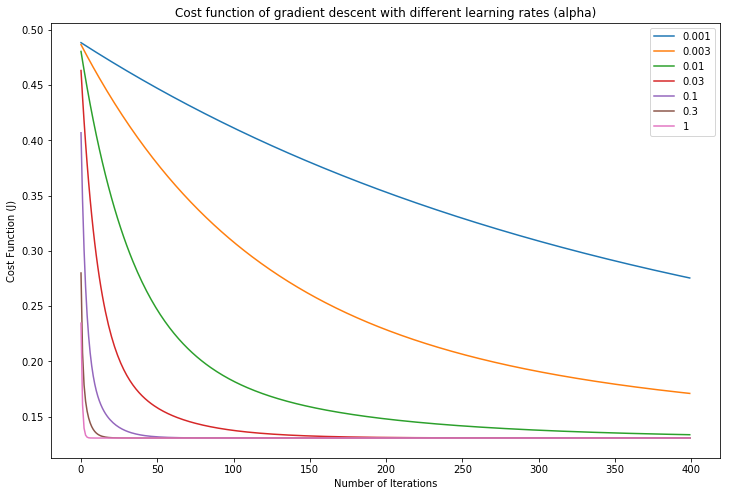

In [335]:
"""
Instructions
------------
We have provided you with the following starter code that runs
gradient descent with a particular learning rate (alpha). 

Your task is to first make sure that your functions - `computeCost`
and `gradientDescent` already work with  this starter code and
support multiple variables.

After that, try running gradient descent with different values of
alpha and see which one gives you the best result.

Finally, you should complete the code at the end to predict the price
of a 1650 sq-ft, 3 br house.

Hint
----
At prediction, make sure you do the same feature normalization.
"""
# Choose some alpha value - change this
#alpha = 0.01
num_iters = 400

# set up plot
fig = plt.figure(figsize=(12,8))
ax = plt.axes()
ax.set_xlabel("Number of Iterations")
ax.set_ylabel("Cost Function (J)")
ax.set_title("Cost function of gradient descent with different learning rates (alpha)")

alphas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]
for alpha in alphas:
    # Initialize theta and run gradient descent
    theta = np.zeros([3,1])
    theta, J_history = gradientDescent(X4, y4, theta, alpha, num_iters)
    # plot J_history
    ax.plot(J_history)
    ax.legend(alphas)
    # Display the gradient descent's result
    # print('theta computed from gradient descent and alpha of {}: \n{:s}'.format(alpha, str(theta)))

Notice the changes in the convergence curves as the learning rate changes. With a small learning rate, we see that gradient descent takes a very long time to converge to the optimal value. Conversely, with a large learning rate, gradient descent might not converge or might even diverge!

Finally, using an appropriate learning rate chosen from the experiment above, we re-run the gradient descent until convergence to find the final values of $\theta$.

We use this value of $\theta$ to predict the price of a house with a floor area of 1,650 square feet and 3 bedrooms. Don’t forget we need to normalize the features when you make this prediction!

Later on will use this predicted value to check our implementation of the <i>normal equations</i>.

In [336]:
# Re-run gradient descent with an alpha of 0.1, and 400 iterations
alpha = 0.01
num_iters = 400
theta = np.zeros([3,1])
theta, J_history = gradientDescent(X4, y4, theta, alpha, num_iters)

# Step 1 - normalize the inputs:
Area = 1650
Area_normed = (Area - X_mean[0]) / X_std[0]
#print("Normed Area = {}".format(Area_normed))
Bedrooms = 3
Bedrooms_normed = (Bedrooms - X_mean[1]) / X_std[1]
#print("Normed No. of Bedrooms = {}".format(Bedrooms_normed))

# Step 2 - calculate the normalized price based on theta
Normalized_inputs = [1, Area_normed, Bedrooms_normed]
#print("Normalized_inputs: {}".format(Normalized_inputs))
Normalized_price = np.dot(Normalized_inputs, theta)
#print("Normalized price is ${}".format(Normalized_price))

# Step 3 - convert the normalized price back into $ amount
price = Normalized_price * X_std[2]
#print("Interim price is {}".format(price))
price = price + X_mean[2]
#print("Interim price is {}".format(price))
priceGD = float(price)
print('Predicted price of a 1,650 sq-ft, 3 br house (using functional implementation of gradient descent): ${:.0f}'.format(priceGD))

Predicted price of a 1,650 sq-ft, 3 br house (using functional implementation of gradient descent): $295425


### 2.3 Normal Equations

Remember for the course's videos (or any other source!) the closed-form solution to linear regression is

$$ \theta = \left( X^T X\right)^{-1} X^T\vec{y}$$

Using this formula does not require any feature scaling, and it will result an exact solution in one calculation: there is no “loop until convergence” like in gradient descent.

**Note however** that when we're dealing with large data sets, the normal equation becomes computationally very expensive! Moreover, some matrices are "non-invertible" - $(X^T X)^{-1}$ cannot be calculated for them - meaning that the normal equation cannot work for them. This is why, in practice in Data Science / Machine Learning, we use gradient descent (or some other approximation method).

First, we will reload the data to ensure that the variables have not been modified. Remember that while we don't need to scale the features, we still need to add a column of 1’s to the <i>X</i> matrix to have an intercept term ($\theta_0$). The code in the next cell will adds the column of <i>1</i>s to <i>X</i>.

In [337]:
# Load data
data = np.loadtxt(os.path.join('Data', 'ex1data2.txt'), delimiter=',')
X = data[:, :2]
y = data[:, 2]
m = y.size
X = np.concatenate([np.ones((m, 1)), X], axis=1)

Now we define a function `normalEqn()` that implements the formula above to calculate $\theta$. 

<a id="normalEqn"></a>

In [338]:
def normalEqn(X, y):
    """
    Computes the closed-form solution to linear regression using the normal equations.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        The value at each data point. A vector of shape (m, ).
    
    Returns
    -------
    theta : array_like
        Estimated linear regression parameters. A vector of shape (n+1, ).
    """
    theta = np.zeros(X.shape[1])
    # calculate X.T dot X
    interim0 = np.dot(X.T, X)
    # calculate inverse of X.t dot X
    interim1  = np.linalg.pinv(interim0)
    # calculate X.T dot y
    interim2 = np.dot(X.T, y)
    # calculate theta
    theta = np.dot(interim1, interim2)
    return theta

    # NOTE - we could calculate this in fewer lines of code, e.g:
        #interim = np.linalg.pinv(np.dot(X.T, X))
        #theta = np.dot(interim, np.dot(X.T, y))
    # BUT, I like to follow the python mantra that "explicit is better than implicit"...
    # ...and therefore break apart into four steps

In [339]:
normalEqn(X, y)

array([ 89597.90954361,    139.21067402,  -8738.01911255])

Now, once you have found $\theta$ using the normal equation method, we can use it to make a price prediction for a 1,650-square-foot house with 3 bedrooms. With luck, we'll find it gives the same predicted price as the value
 obtained using the model fit with gradient descent (in Section 2.2.3 above).

In [340]:
# Calculate the parameters from the normal equation
theta = normalEqn(X, y);

# Display normal equation's result
# print('Theta computed from the normal equations: {:s}'.format(str(theta)));

# Estimate the price of a 1650 sq-ft, 3 br house

# Step 1 - create a numpy array containing our test variables
variables = np.array([1, 1650, 3])

# Step 2 - calculate the price

# one option - calculate using a loop:
#price = 0
#for i in range(len(theta)):
#    price += theta[i] * variables[i]

# preferred option - calculate directly using vectorisation:
priceN = np.dot(variables, theta)
    
print('Predicted price of a 1,650 sq-ft, 3 bedroom house (using normal equations): ${:.0f}'.format(priceN))
print('Predicted price of a 1,650 sq-ft, 3 bedroom house (using gradient descent and {} iterations): ${:.0f}'.format(num_iters, priceGD))

Predicted price of a 1,650 sq-ft, 3 bedroom house (using normal equations): $293081
Predicted price of a 1,650 sq-ft, 3 bedroom house (using gradient descent and 400 iterations): $295425


As we can see, the predicted values that result from using the Normal Equations and from Gradient Descent are slightly different (0.8%)

## 3 An object-oriented implementation of linear regression

Instead of the **functional** approach we've used above, we can also implement an **object-oriented** approach - which is arguably more "Pythonic".
The approach I will follow uses the same gradient-descent approach to minimize the ordinary least squares cost function that we used above.

For reference, see the excellent "<i>Python Machine Learning</i>" by Sebastian Raschka and Vahid Mirjalili.

In [341]:
# define our linear regression object
class LinearRegressionGD (object):
    def __init__(self, eta = 0.01, num_iters = 400):
        self.eta = eta
        self.num_iters = num_iters
        
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.num_iters):
            output = self.net_input(X)
            output = output[:, np.newaxis]
            errors = (y - output)

            # Now, in the Raschka & Mirjalili textbook, the next line is:
            # self.w_[1:] += self.eta * X.T.dot(errors) 
            # ...which updates the weights in self.w_[1] and onwards
            # ...where both self.eta and X.T.dot(errors) are scalars - i.e. floats
            # However, because WE are using MATRICES in numpy, the output of X.T.dot(errors)
            # ...is a 1 x 1 matrix (as we will see if we allow the print statements in line 24 below)
            # so I convert it to a float (scalar) by summing over the 1 x 1 matrix
            temp = X.T.dot(errors)
            # print("temp is {}, of shape {}".format(temp, temp.shape))
            temp = temp.sum()
            # print("temp is now {}".format(temp))
            self.w_[1:] += self.eta * temp
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict (self, X):
        return self.net_input(X)

To see how this works, let's start by running a **univariate** linear regerssion - just using floor area as our explanatory variable.

We've already normalized our inputs from X and y above, so we can use them as our input variable X (our independent, or "explanatory" variable), and the price as our output variable y (or "dependent" variable)

In [342]:
X_norm.head()

,Ones,Size,Bedrooms,Price
0,1.0,0.130010,-0.223675,0.475747
1,1.0,-0.504190,-0.223675,-0.084074
2,1.0,0.502476,-0.223675,0.228626
3,1.0,-0.735723,-1.537767,-0.867025
4,1.0,1.257476,1.090417,1.595389


In [343]:
X_norm.shape[1]

4

In [344]:
X = X_norm[['Size']].values

In [345]:
y = X_norm[['Price']].values

In [346]:
X.shape

(47, 1)

In [347]:
y.shape

(47, 1)

Let's run our model. First we instantiate a LinearRegressionGD object:

In [348]:
lr = LinearRegressionGD()

Then we call the fit() method on our normalized inputs:

In [349]:
lr.fit(X, y)

The output `<__main__.LinearRegressionGD at 0x115f35cf8>` shows we have created a linear regression object

Now let's plot the cost function of our linear regression instantiation against the number of iterations:

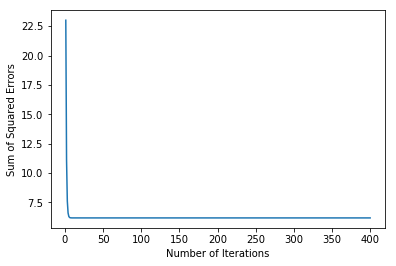

In [350]:
plt.plot(range(1, lr.num_iters+1), lr.cost_)
plt.ylabel("Sum of Squared Errors")
plt.xlabel("Number of Iterations")
plt.show()

Now let's define a quick function that will let us plot our model:

In [351]:
def lin_reg_plot(X, y, model):
    plt.scatter(X, y, c = 'steelblue', edgecolor = "white", s = 70)
    plt.plot(X, model.predict(X), color = "black", lw = 2)
    return None

Now we can visualize how well the linear regression line we've calculated using this object oriented approach fits the data:

<function matplotlib.pyplot.show>

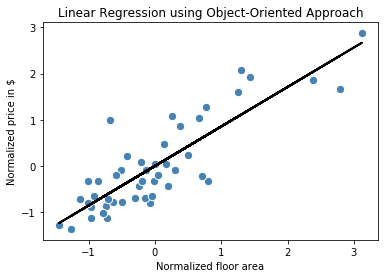

In [352]:
lin_reg_plot(X, y, lr)
plt.xlabel("Normalized floor area")
plt.ylabel("Normalized price in $")
plt.title("Linear Regression using Object-Oriented Approach")
plt.show

It doesn't make a lot of sense to compare the predicted price from this **univariate** model with the outputs from models based on two variables. So let's go ahead and run a **multivariate** model using this object-oriented approach.

But before we do this, there's something to notice about this implementation and the example we've tested.

(If I've understood the code correctly), unlike our previous two implementations , the object-oriented implementation from Raschka and Mirjalili **doesn't** require us to have data with an additional column of $1$s.

Look at the definition of the `net_input()` method: it calculates the inner product between X and $\theta_1$ to n - <i>and then separately</i> adds on the value of $\theta_0$

So, to run a multivariate linear regression using *this* code, we're going to have to do the following:
- Pull out a normed data set excluding the leading $1$s
- Run our model on this
- Then predict our house price

Let's give it a go!

First we extract our X values:

In [353]:
# Extract JUST the normalized values of Size and Bedrooms into a new dataframe
X = X_norm[['Size', 'Bedrooms']]

In [354]:
X.head()

,Size,Bedrooms
0,0.130010,-0.223675
1,-0.504190,-0.223675
2,0.502476,-0.223675
3,-0.735723,-1.537767
4,1.257476,1.090417


We've already pulled out the y values above, so we should be able to just run the model:

In [355]:
lr2 = LinearRegressionGD()

In [356]:
lr2.fit(X, y)

Again let's plot the cost function of our linear regression instantiation against the number of iterations:

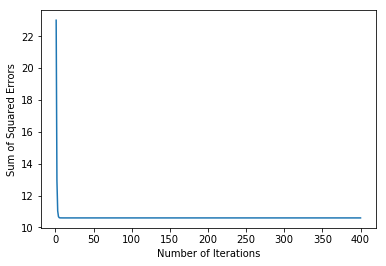

In [357]:
plt.plot(range(1, lr2.num_iters+1), lr2.cost_)
plt.ylabel("Sum of Squared Errors")
plt.xlabel("Number of Iterations")
plt.show()

Looking good

Since we've now got two input variables (two features), plotting the linear regression against the data is going to be a bit more tricky - it will be a plane in a 3-d space. To be honest, I haven't got the patience right now to re-write the function we wrote way back in **section 1.3** to work with our object-oriented approach.

Finally, let's check whether this approach gives us the same predicted price for a 1,650 square foot, 3 bedroom house. We can use our `Normalized_inputs` object from section 2.2.3 above:

In [358]:
# First we need to generate the right kind of input for the `predict()` method.
# ...it requires a numpy array (a vector) containing the normalized values we are trying to predict
# ...which are the normalized area and the normalized number of bedrooms (taken from section 2.2.3 above)
input = np.array([Area_normed, Bedrooms_normed])

# Now we can calculate the predicted (normalized) price
normalized_price = lr2.predict(input)

# Then we convert the normalized price back into $ amount
interim_price = normalized_price * X_std[2]
#print("Interim price is {}".format(interim_price))
price = interim_price + X_mean[2]
#print("Interim price is {}".format(price))
priceOO2 = float(price)

print('Predicted price of a 1,650 sq-ft, 3 bedroom house (using functional implementation of gradient descent): \n${:.0f}'.format(priceGD))
print('Predicted price of a 1,650 sq-ft, 3 bedroom house (using normal equations): \n${:.0f}'.format(priceN))
print('Predicted price of a 1,650 sq-ft, 3 bedroom house (using an ojbect-oriented implementation of multivariate linear regression): \n${:.0f}'.format(priceOO2))

Predicted price of a 1,650 sq-ft, 3 bedroom house (using functional implementation of gradient descent): 
$295425
Predicted price of a 1,650 sq-ft, 3 bedroom house (using normal equations): 
$293081
Predicted price of a 1,650 sq-ft, 3 bedroom house (using an ojbect-oriented implementation of multivariate linear regression): 
$305841


I have to say, I'm surpised by how different the predictions of the <i>functional</i> and <i>object-oriented</i> implementations are - they're both using the same parameters (alpha of 0.01 and 400 iterations); but the predicted price is nearly 4% different.

## 4 Using the <i>scikitlearn</i> library

Finally, the way I'd do this in practice - using pre-built industrial-strength libraries!

For this example, I'll use the widely-used <i>scikitlearn</i> library.

For reference, see:
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- <i>Python Machine Learning</i> by Sebastian Raschka and Vahid Mirjalili

### 4.1 Importing `scikitlearn` and fitting a model

We need to import the relevant libraries, and then we can fit a model of (normalized floor area, number of bedrooms and price).

Note that we don't need to have a column of leadings $1$s as scikitlearn's algorithm takes care of that for us. This means we can use the same input data that we just created for our multivariate object-oriented implementation.

In [360]:
# import scikitlearn's Linear Regression object from the linear_model sub-library
from sklearn.linear_model import LinearRegression
# instantiate a LinearRegression object
slr = LinearRegression()
slr.fit(X, y)
print("Slope: {}".format(slr.coef_))
print("Intercept: {}".format(slr.intercept_))
print("X's shape is {}".format(X.shape))
print("y's shape is {}".format(y.shape))

Slope: [[ 0.88476599 -0.05317882]]
Intercept: [ -9.26852330e-17]
X's shape is (47, 2)
y's shape is (47, 1)


Plotting this is going to be tricky since we're using two input dimensions / features (Floor Area and No. of Bedrooms...normalized)

In [361]:
R2 = slr.score(X, y)
print("R-squared of our model is {}".format(R2))

R-squared of our model is 0.7329450180289143


Finally, let's once again predict the price of a 1,650 square foot area house, using the model we've just created using `scikitlearn`:

In [362]:
# First we predict the normalized price based on the normalized area (taken from section 2.2.3 above)
normalized_price = slr.predict(input)

# Then we convert the normalized price back into $ amount
interim_price = normalized_price * X_std[2]
#print("Interim price is {}".format(interim_price))
price = interim_price + X_mean[2]
#print("Interim price is {}".format(price))
priceScikitlearn = float(price)

print('Predicted price of a 1,650 sq-ft, 3 bedroom house (using functional implementation of gradient descent): \n${:.0f}'.format(priceGD))
print('Predicted price of a 1,650 sq-ft, 3 bedroom house (using normal equations): \n${:.0f}'.format(priceN))
print('Predicted price of a 1,650 sq-ft, 3 bedroom house (using an ojbect-oriented implementation of linear regression): \n${:.0f}'.format(priceOO2))
print('Predicted price of a 1,650 sq-ft, 3 bedroom house (using scikitlearn): \n${:.0f}'.format(priceScikitlearn))

Predicted price of a 1,650 sq-ft, 3 bedroom house (using functional implementation of gradient descent): 
$295425
Predicted price of a 1,650 sq-ft, 3 bedroom house (using normal equations): 
$293081
Predicted price of a 1,650 sq-ft, 3 bedroom house (using an ojbect-oriented implementation of linear regression): 
$305841
Predicted price of a 1,650 sq-ft, 3 bedroom house (using scikitlearn): 
$293081


/Users/Matt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Interestingly, scikitlearn's default parameters produce the same predicted price as the Normal Equation implementation.

### 4.2 Interpretation, training and testing

What we've done above is to take **all** of the data-points for size (actually, floor area in square metres) and price (in $) - both normalized - and calculate the ordinary least squares linear relationship between them. In the machine-learning world this is called "training the model".

Before we go any further, we should interpret this result.

Firstly, let's look at the slope - 0.85. This tells us that, according to our model, for every unit increase in floor area, we have a 0.85 increase in the price.

We then calculated the "coefficient of determination" (R^2) to understand the strength of the relationship - where an R^2 of 1 represents a perfect prediction, and an R^2 of 0 represents no predictive value. The R^2 of 0.73 represents a reasonably strong relationship between the independent variable (floor area) and the dependent variable (price) - 73% of the variation in the price is explained by the floor area.

This leads to an interesting question - how large is a "strong" relationship? i.e. how big should R^2 be for us to conclude that our model (linear equation) is able to predict the data well?

We want to know this because we'd like to be confident that the model can generalize to data it wasn't "trained" on; i.e. we want to test whether the linear relationship we've calculated in the form $y = mx + c$
is able to accurately predict <i>new</i> values of <i>y</i> given <i>new</i> values of <i>x</i>.

**Statisticians** might approach this as follows:
- To start with, they might point out that the size of the R^2 may not be as important as the <i>significance</i> of the relationship. For example, results in psychology often have R^2 values below 0.5 - because human behaviour is hard to predict! Nonetheless, being able to predict half of the variation in a particular behaviour from some other independent variable might be a hugely important and valuable result.
- From there, they'd probably go on to **test the significance** of the regression model, using the F-test of overall significance in regression (see e.g. https://blog.minitab.com/blog/adventures-in-statistics-2/what-is-the-f-test-of-overall-significance-in-regression-analysis). If the F-test is significant, it shows that the R^2 value is significantly different from zero - and the model improved the fit of data (vs. a model that just goes horizontally through the intercept).
- They'd also say: "plot the residuals" (i.e. the differences between the predicted outputs and the actual outputs) to see whether these are randomly distributed, or whether there is any systematic bias in the model's output.

So, let's plot the residuals:

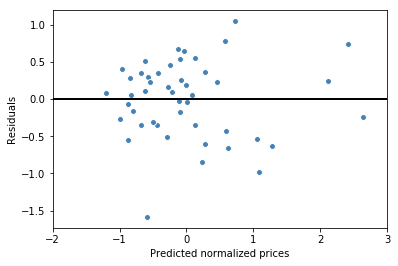

In [363]:
# predict (normalized) prices for all of the (normalized) data (floor area)
normalized_predicted_prices = slr.predict(X)
residuals = normalized_predicted_prices - y
# plot the residuals vs. the normalized predicted prices
plt.scatter(normalized_predicted_prices, residuals, c='steelblue', marker = 'o', edgecolor='white')
plt.xlabel("Predicted normalized prices")
plt.ylabel("Residuals")
plt.hlines(y=0, xmin = -2, xmax = 3, color='black', lw=2)
plt.xlim(-2, 3)
plt.show()

The residuals appear to be relatively evenly and randomly spread around 0, which is good - this suggests that there's no systematic bias in the model's output.

We can also use residual plots to detect <i>outliners</i>, which are represented by points a long way from the centre line (e.g. the point at around -0.6, -1.6 to the lower left of the residual plot above).

**Machine Learning** or **Data Science** people seem to follow a different approach. Rather than using statistical tests, it seems that the standard approach is to:
- segment the data into separate "training" and "testing" sub-sets
- build the model on the "training" data (i.e. estimate the values of parameters in our $y = mx + c$ equation)
- use the "trained model" to predict the expected outputs for the "training" data
- compare these predicted values with the actual values of the training data. If these are "close enough", conclude that the model is acceptably good at predicting the output (dependent) variable based on new "unseen" values of the dependent variable (or variables if we are running multivariate regression).

In [364]:
# import scikitlearn's "test_train_split" module
from sklearn.model_selection import train_test_split
# separate the data into "train" and "test" portions
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)
# check we've got the shapes we were expecting
print("X_train's shape is {}".format(X_train.shape))
print("y_train's shape is {}".format(y_train.shape))
print("X_test's shape is {}".format(X_test.shape))
print("y_test's shape is {}".format(y_test.shape))

X_train's shape is (32, 2)
y_train's shape is (32, 1)
X_test's shape is (15, 2)
y_test's shape is (15, 1)


In [365]:
# "fit" the model on our training data
# ...(i.e. we calculate y = mx +c using ordinary least squares for the training sub-set of our data)
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now we can evaluate the performance of the model using the Mean Squared Error and the $R^2$ statistic. This is a standardized version of the Mean Square Error, and captures the fraction of the response variance that is captured by the model.

The Mean Squared Error, or MSE, is defined as:

$$ MSE = \frac{1}{n} \sum_{i=1}^n \left( y^{(i)} - \hat{y}^{(i)}\right)^{2} $$

The $R^2$ statistic is defined as:

$$ R^2 = 1 - \frac{SSE}{SST} $$

Where the SST is the Total Sum of Squares - i.e. the variance of the response:

$$ SST = \sum_{i=1}^n \left( y^{(i)} - \mu_{y}\right)^{2} $$

First, let's look at the MSE:

In [366]:
# import the mean_squared_error() method from scikitlearn.metrics
from sklearn.metrics import mean_squared_error
# instantiate the predicted outputs for the training and test variables from our model
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)
print("MSE train: {}".format(mean_squared_error(y_train, y_train_pred)))
print("MSE test: {}".format(mean_squared_error(y_test, y_test_pred)))

MSE train: 0.19766683389081785
MSE test: 0.39789978581985064


We can see that the MSE for the training data is ~0.2, while the MSE for the test data is ~0.4 - indicating that the model is likely over-fitting the training data.

Now let's have a look at the $R^2$ scores. Note that we don't need to calculate these directly, since `scikitlearn` can do this for us with its `score()` method:

In [367]:
# "score" the model's ability to predict the training data (i.e. calculate the R^2 for this data)
R2_train = lm.score(X_train, y_train)
print("R-squared for training data is {}".format(R2_train))
# "score" the model's ability to predict the test data (i.e. calculate the R^2 for this data)
R2_test = lm.score(X_test, y_test)
print("R-squared for unseen data is {}".format(R2_test))

R-squared for training data is 0.7843320596420005
R-squared for unseen data is 0.6394802354870255


What does this tell us?

Well, literally, what the $R^2$ scores are telling us is that the model built on the traning data can explain ~78% of the variance in the training data; and when we use this model to predict the output values of the (previously unseen) training sub-set of the data, it can explain ~64% of the variance in the data.

This matches what we are seeing with the "raw" MSE scores.

Something that's suprising, though is that when we calculate the model - i.e. work out the formula $y = mc + c$

using a sub-set of the data, we get a **higher** $R^2$ score (~0.78) than when we calculate it using **all of the data** (~0.73). This isn't good. If we've selected an appropriately random and representative subset of the data to be the training set, we wouldn't expect a smaller set of data to result in a model that accounts for <i>more of the variance in the data</i>. Again, this suggests that our model based on the training set is over-fitting the data to a worrying degree.

Overcoming these issues would merit a further discussion on validation and the various techniques that can be used to achieve that (e.g. <i>k-fold validation</i>, <i>leave-one-out validation</i>) - which is a topic for another time.

It would also be useful to look in more detail at overfitting, and the use of the
- <i>adjusted $R^2$</i> and
- <i>predicted $R^2$</i> statistics

and what they can tell us about overfitting (as a final note - overfitting can occur through either or both of: adding new predictor terms to our multiple regression; or adding polynomial terms - basically in both cases we start to accurately model the <i>noise</i> in the data, rather than the actual relationships).

## 5 Final Thoughts to Wrap Up

That's everything we need to do for this week's exercise for the Andrew Ng Machine Learning course (week 2).

However, there are some next steps and/or further areas to explore that I'd like to note, which I - or you! - could come back to as and when you have the time:


### 5.1 Outliers
We might want to examine our data to see whether there are any outliers that are resulting in strange / inappropriate results (i.e. skewing our model so that it's *less* representative of the data than it could be). We could look at this using e.g. a *Random sample consensus* algorithm (RANSAC) - which is already implemented in scikitlearn.

### 5.2 Polynomial Regression
Sometimes, the relationship between two (or more) variables is not a straight line - it's a curve - e.g. it might be of the form:

$$ y = m{x}^2 + c $$

In this case, we can reduce the mean squared error ($MSE$) by fitting a polynomial rather than a linear relationship.

**Note** however that the more terms we introduce, simply by the arithmetic of it all, the higher the $R^2$ is going to be - meaning that we can *artificially* improve the apparent fit of our model, just by introducing more and more parameters powers.

I'm not going to go into this in detail here - but think of it like this: if we have a finite number of data points, we can always fit *some* curve to it such that the curve will meet *all* of the data points. However, when we try to extrapolate this to previously unseen data (from the same population), it's very unlikely to fit well - effectively we've fit the curve to the *noise* in the data.

Which leads on to the next point.

### 5.3 Over-fitting and "regularization"
There are a number of approaches and algorithms that we could use to make it less likely that we over-fit our model to the data. I won't go into them here, but they include:
- Ridge Regression;
- Least Absolute Shrinkage and Selection Operator (LASSO); and
- Elastic Net
